# A Benchmarking Tool for cuDF vs. Pandas Performance 

### Context and Introduction 

What do self-driving cars, recommender systems, and spam filters have in common? The answer is that they are all powered by Artificial Intelligence. In recent years, data scientists and engineers have been tasked with “cleaning up” large datasets so that they can feed this data into Artificial Intelligence models. One of the most popular technologies to “clean up” datasets today is pandas, a CPU based DataFrame library. However, one huge drawback of pandas is that it has poor performance on large datasets. 

In response to this clear need, NVIDIA released cuDF, a GPU-based DataFrame library. Since cuDF and pandas have identical syntax (refer to graphic below), it is very easy for data scientists and engineers to adapt to this new library. In order to demonstrate cuDF’s computational advantage, we have developed a tool that automatically benchmarks the time(s) that cuDF and pandas take for common DataFrame operations. The data we are using for this tool is from the New York City taxi dataset, divided month by month  This is done in 2 formats, a Command Line Interface (CLI) and a Jupyter Notebook. 


### Prerequisites 

To proceed to the next steps, these instructions that you have the following already installed:

##### GPU: NVIDIA Pascal™ or better with compute capability 6.0+
##### CUDA version 10.0+ (with NVIDIA drivers)
##### OS: Ubuntu 16.04/18.04 
##### Docker CE v19.03+ and nvidia-container-toolkit (if using docker container)


## Set up RAPIDS Docker Container 

In order to set up the docker container, **follow the instructions in the README (on the home page)** in this repository

# Library Imports

In [25]:
import cudf
import pandas as pd 
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn as sns
import gcsfs

graph_data = []
cudf_barplot_data = []

# Functions For Each Benchmarking Operation
#### Note: The cells need to be run so that the benchmarking tool runs without issues in the later cells.

## Applying a numerical function on a column (af)
##### Note: Here, we are converting the trip distance (in miles) to the trip distance in kilometers.

In [26]:
def apply_numerical_function(nyc_taxi_data, nyc_cudf_taxi_data):
    print("Pandas: Applying a numerical function (converting mi to km):")
    func_copy_nyc_taxi_data = nyc_taxi_data
    load_df_timer_func = Timer()
    load_df_timer_func.start()
    func_copy_nyc_taxi_data['trip_distance'] = func_copy_nyc_taxi_data['trip_distance'].apply(lambda x: 1.60934 * x)
    load_df_timer_func.stop()

    df_time = load_df_timer_func.total_time
    graph_data.append(["af", round(df_time, 3), "pandas"])

    print("CuDF: Applying a numerical function (converting mi to km):")
    func_copy_nyc_taxi_data_cudf = nyc_cudf_taxi_data
    load_cudf_timer_func = Timer()
    load_cudf_timer_func.start()
    func_copy_nyc_taxi_data_cudf['trip_distance'] = func_copy_nyc_taxi_data_cudf['trip_distance'].applymap(lambda x: 1.60934 * x)
    load_cudf_timer_func.stop()

    cudf_time = load_cudf_timer_func.total_time
    graph_data.append(["af", round(cudf_time, 3), "cuDF"])

    speedup = round(float(df_time) / float(cudf_time), 3)
    cudf_barplot_data.append(["af", speedup])
    print("Speedup: " + str(speedup) + "X")

## Applying aggregate function on a column (aggfunc)
#### These include .sum(), .min(), .max() .... 

In [27]:
def apply_aggregate_function(nyc_taxi_data, nyc_cudf_taxi_data):
        
    print("Pandas: Applying an aggregate function:")
    func_copy_nyc_taxi_data = nyc_taxi_data
    load_df_timer_afunc = Timer()
    load_df_timer_afunc.start()
    func_copy_nyc_taxi_data['fare_amount'].sum()
    load_df_timer_afunc.stop()

    df_time = load_df_timer_afunc.total_time
    graph_data.append(["aggfunc", round(df_time, 3), "pandas"])

    print("CuDF: Applying an aggregate function:")
    func_copy_nyc_taxi_data_cudf = nyc_cudf_taxi_data
    load_cudf_timer_afunc = Timer()
    load_cudf_timer_afunc.start()
    func_copy_nyc_taxi_data_cudf['fare_amount'].sum()
    load_cudf_timer_afunc.stop()

    cudf_time = load_cudf_timer_afunc.total_time
    graph_data.append(["aggfunc", round(cudf_time, 3), "cuDF"])

    speedup = round(float(df_time) / float(cudf_time), 3)
    cudf_barplot_data.append(["aggfunc", speedup])
    print("Speedup (cuDF): " + str(speedup) + "X")

## GroupBy + Aggregation (gb)

In [28]:
def groupby(nyc_taxi_data, nyc_cudf_taxi_data):

    print("Pandas: GroupBy:")
    df_groupby_timer = Timer()
    df_groupby_timer.start()
    nyc_taxi_data.groupby(['payment_type']).size()
    df_groupby_timer.stop()

    df_time = df_groupby_timer.total_time
    graph_data.append(["gb", round(df_time, 3), "pandas"])

    print("CuDF: GroupBy: ")
    cudf_groupby_timer = Timer()
    cudf_groupby_timer.start()
    nyc_cudf_taxi_data.groupby(['payment_type']).size()
    cudf_groupby_timer.stop()

    cudf_time = cudf_groupby_timer.total_time
    graph_data.append(["gb", round(cudf_time, 3), "cuDF"])

    speedup = round(float(df_time) / float(cudf_time), 3)
    cudf_barplot_data.append(["gb", speedup])
    print("Speedup: " + str(speedup) + "X")

## Sorting Values - Getting top 5 entries in a column (gt5)

In [29]:
def get_top_5(nyc_taxi_data, nyc_cudf_taxi_data):

    print("Get Top 5 Longest Trip Distances (Sorting values) w/ Pandas")

    df_topk_timer = Timer()
    df_topk_timer.start()
    t5_longest_taxi_distances = nyc_taxi_data.sort_values(by='trip_distance', ascending=False)
    df_topk_timer.stop()

    df_time = df_topk_timer.total_time
    graph_data.append(["gt5", round(df_time, 3), "pandas"])

    print("Get Top 5 Longest Trip Distances (Sorting Values) w/ cuDF")

    cudf_top_k_timer = Timer()
    cudf_top_k_timer.start()
    t5_longest_taxi_distances_cudf = nyc_cudf_taxi_data.sort_values(by='trip_distance', ascending=False)
    cudf_top_k_timer.stop()

    cudf_time = cudf_top_k_timer.total_time
    graph_data.append(["gt5", round(cudf_time, 3), "cuDF"])

    speedup = round(float(df_time) / float(cudf_time), 3)
    cudf_barplot_data.append(["gt5", speedup])
    print("Speedup: " + str(speedup) + "X")

## Dropping Duplicate Rows (dd)

In [30]:
def drop_duplicates(nyc_taxi_data, nyc_cudf_taxi_data):

    print("Dropping Duplicates - Pandas")
    df_duplicatedrop = nyc_taxi_data

    dup_drop_df_timer = Timer()
    dup_drop_df_timer.start()
    df_duplicatedrop = df_duplicatedrop.drop_duplicates()
    dup_drop_df_timer.stop()
    
    df_time = dup_drop_df_timer.total_time
    graph_data.append(["dd", round(df_time, 3), "pandas"])

    print("Dropping Duplicates - cuDF")

    cudf_duplicatedrop = nyc_cudf_taxi_data

    dup_drop_cudf_timer = Timer()
    dup_drop_cudf_timer.start()
    cudf_duplicatedrop = cudf_duplicatedrop.drop_duplicates()
    dup_drop_cudf_timer.stop()
    
    cudf_time = dup_drop_cudf_timer.total_time
    graph_data.append(["dd", round(cudf_time, 3), "cuDF"])
    
    speedup = round(float(df_time) / float(cudf_time), 3)
    cudf_barplot_data.append(["dd", speedup])
    print("Speedup: " + str(speedup) + "X")

## Dropping a Column (dc)

In [31]:
def drop_column(nyc_taxi_data, nyc_cudf_taxi_data):
    

    print("Drop a column: Pandas")
    col_drop_df = nyc_taxi_data


    col_drop_df_timer = Timer()
    col_drop_df_timer.start()
    col_drop_df = col_drop_df.drop(['mta_tax'], axis=1)
    col_drop_df_timer.stop()

    df_time = col_drop_df_timer.total_time
    graph_data.append(["dc", round(df_time, 3), "pandas"])

    #Dropping a Column - cuDF 

    print("Drop a column: cuDF")
    col_drop_cudf = nyc_cudf_taxi_data

    col_drop_cudf_timer = Timer()
    col_drop_cudf_timer.start()
    col_drop_cudf = col_drop_cudf.drop(['mta_tax'], axis=1)
    col_drop_cudf_timer.stop()

    cudf_time = col_drop_cudf_timer.total_time
    graph_data.append(["dc", round(cudf_time, 3), "cuDF"])

    speedup = round(float(df_time) / float(cudf_time), 3)
    cudf_barplot_data.append(["dc", speedup])
    print("Speedup: " + str(speedup) + "X")

## Filter by Column (fc)

In [32]:
def filter_by_column(nyc_taxi_data, nyc_cudf_taxi_data):
    

    print("Filter by Column Values - pandas")
    row_filt_df = nyc_taxi_data 

    row_filt_df_timer = Timer()
    row_filt_df_timer.start()
    row_filt_df = row_filt_df[row_filt_df['total_amount'] >= 20]
    row_filt_df_timer.stop()

    df_time = row_filt_df_timer.total_time
        
    graph_data.append(["fc", round(df_time, 3), "pandas"]) #add for visualization

        #Filtering Rows Based on their individual feature values - cuDF (on NYC Taxi Data)

    print("Filter by Column Values - cuDF")
    row_filt_cudf = nyc_cudf_taxi_data

    row_filt_cudf_timer = Timer()
    row_filt_cudf_timer.start()
    row_filt_cudf = row_filt_cudf[row_filt_cudf['total_amount'] >= 20]
    row_filt_cudf_timer.stop()

    cudf_time = row_filt_cudf_timer.total_time
    graph_data.append(["fc", round(cudf_time, 3), "cuDF"])

    speedup = round(float(df_time) / float(cudf_time), 3)
    cudf_barplot_data.append(["fc", speedup])
    print("Speedup (cuDF): " + str(speedup) + "X")

## Rewrite To .csv file (rtc)

In [33]:
def rewrite_to_csv(nyc_taxi_data, nyc_cudf_taxi_data):

    print("Rewriting to .csv - Pandas")

    rewrite_df = nyc_taxi_data
    rewrite_df_timer = Timer()
    rewrite_df_timer.start()
    rewrite_df.to_csv("rewritten_nyc_taxi_data_df.csv")
    rewrite_df_timer.stop()
    
    df_time = rewrite_df_timer.total_time
    graph_data.append(["rtc", round(df_time, 3), "pandas"])

    print("Rewriting to .csv - cuDF")

    #Rewriting to .csv - cuDF 
    rewrite_cudf = nyc_cudf_taxi_data
    rewrite_cudf_timer = Timer()
    rewrite_cudf_timer.start()
    rewrite_cudf.to_csv("rewritten_nyc_taxi_data_cudf.csv")
    rewrite_cudf_timer.stop()
    
    cudf_time = rewrite_cudf_timer.total_time
    graph_data.append(["rtc", round(cudf_time, 3), "cuDF"])
    
    speedup = round(float(df_time) / float(cudf_time), 3)
    cudf_barplot_data.append(["rtc", speedup])
    print("Speedup: " + str(speedup) + "X")

## Filling in Null Values (fnv)
#### Note: All the columns (w/ null values) have to be the same datatype for this to work in cuDF!

In [34]:
def fill_null_values(nyc_taxi_data, nyc_cudf_taxi_data):
    
    print("Filling in null values - Pandas")
    
    copy_nyc_taxi_data = nyc_taxi_data
    fill_null_vals = Timer()
    fill_null_vals.start()
    copy_nyc_taxi_data = copy_nyc_taxi_data.fillna(0)
    fill_null_vals.stop()
    
    df_time = fill_null_vals.total_time
    graph_data.append(["fnv", round(df_time, 3), "pandas"])
    
    print("Filling in null values - cuDF")
    
    copy_nyc_cudf_taxi_data = nyc_cudf_taxi_data
    copy_nyc_cudf_taxi_data = copy_nyc_cudf_taxi_data.drop(columns=['store_and_fwd_flag'])
    fill_null_vals_cudf = Timer()
    fill_null_vals_cudf.start()
    copy_nyc_cudf_taxi_data = copy_nyc_cudf_taxi_data.fillna(0)
    fill_null_vals_cudf.stop()
    
    cudf_time = fill_null_vals_cudf.total_time
    graph_data.append(["fnv", round(cudf_time, 3), "cuDF"])
    
    speedup = round(float(df_time) / float(cudf_time), 3)
    cudf_barplot_data.append(["fnv", speedup])
    print("Speedup (cuDF): " + str(speedup) + "X")
    

## Inner Join on NYC Taxi Data (merge)

In [35]:
def merge_data(df_data, cudf_data):
    
    rcid_to_meaning_df = pd.read_csv('rcid_to_meaning.csv')
    rcid_to_meaning_cudf = cudf.read_csv('rcid_to_meaning.csv')
        
    rcid_to_meaning_df.columns = ['rate_code', 'Meaning']
    rcid_to_meaning_cudf.columns = ['rate_code', 'Meaning']
    
    #rcid_to_meaning_df = rcid_to_meaning_df[]
        
    print("Inner Join (merge) - Pandas")
    df_merge_timer = Timer() 
    df_merge_timer.start()
    new_data_df = df_data.merge(rcid_to_meaning_df, on=['rate_code'], how='inner')
    df_merge_timer.stop()
        
    df_time = df_merge_timer.total_time 
    graph_data.append(["merge", round(df_time, 3), "pandas"])
        
    print("Inner Join (merge) - cuDF ")
    cudf_merge_timer = Timer()
    cudf_merge_timer.start()
    new_data_cudf = cudf_data.merge(rcid_to_meaning_cudf, on=['rate_code'], how='inner')
    cudf_merge_timer.stop()
        
    cudf_time = cudf_merge_timer.total_time 
    graph_data.append(["merge", round(cudf_time, 3), "cuDF"])
        
    speedup = round(float(df_time) / float(cudf_time), 3)
    cudf_barplot_data.append(["merge", speedup])
    print("Speedup (cuDF): " + str(speedup) + "X")

# Loading the Data For Benchmarking - Helper Functions (used later on)

### Timer Class - Used for Benchmarking (Link at: https://realpython.com/python-timer/) 

In [36]:
import time

class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    total_time = 0
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        Timer.total_time = elapsed_time
        self._start_time = None
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")

### Validate Arguments 

In [37]:
def validate_args(argmap):
    
    valid_operations = ['af', 'gb', 'gt5', 'dd', 'dc', 'fc', 'rtc', 'ld', 'all', 'cdf', 'fnv', 'aggfunc', 'merge']
    check_operation = argmap['operation'] in valid_operations
    
    num_months = argmap['num_months']
    
    if check_operation:
        if int(num_months) <= 36:
            return True
        else: 
            return "Invalid Arguments Inputted. Refer to documentation, examples, and the files in the GCP Bucket for additional info"

### Category (based on Number of Months) --> See if we need to pull 1,2, or 3 years of data

In [38]:
def get_category(num_months):
    
    #Category 1 --> 1-12 Months
    if num_months >= 1 and num_months <= 12:
        return 1
    
    #Category 2 --> 13-24 Months
    if num_months >= 13 and num_months <= 24:
        return 2
    
    #Category 3 --> 25-36 Months
    if num_months >= 25 and num_months <= 36:
        return 3

### Relabelling Columns (so month-to-month data can be merged)

In [39]:
# Relabel column names (e.x. VendorID --> vendor_id) so that month-to-month data can be merged
    
def relabel_taxi_data(monthly_taxi_data):
    monthly_taxi_data.columns = ['vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'rate_code', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type',
       'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount']
    return monthly_taxi_data
    
# Relabel column names (e.x. VendorID --> vendor_id) so that month-to-month data can be merged
def relabel_taxi_data_v2(monthly_taxi_data):
    monthly_taxi_data = monthly_taxi_data.drop(columns=['improvement_surcharge'])
    monthly_taxi_data.columns = ['vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'rate_code', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type',
       'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount']
    return monthly_taxi_data

### Loading Data from public GCP Bucket (using cudf)

In [40]:
def load_data_cudf(argmap):
    
    num_months = int(argmap['num_months'])
    operation = argmap['operation']
    
    category = get_category(num_months)
    
    datasets = []
    

    if category == 1:
        for m in range(1, num_months + 1):
            #Necessary because filepath for Jan - Sept ends in '2014-01.csv' but the filepath for Oct - Dec ends in '2014-11.csv'
            if m >= 1 and m <= 9:
                monthly_taxi_data = cudf.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2014/yellow' + '_tripdata_' + '2014-0' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data(monthly_taxi_data)
                datasets.append(monthly_taxi_data)
            else:
                monthly_taxi_data = cudf.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2014/yellow' + '_tripdata_' + '2014-' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data(monthly_taxi_data)
                datasets.append(monthly_taxi_data)
                
        '''If the user wants to benchmark concatenating data in pandas/cudf, then this returns the month-by-month data
        Otherwise, the month-by-month data is combined together'''
        if operation == 'cdf':
            return datasets
        else:
            final_dataset = cudf.concat(datasets)
            return final_dataset
                
    if category == 2:
        
        rem_mo = num_months - 12
        
        for m in range(1, 13):
            if m >= 1 and m <= 9:
                monthly_taxi_data = cudf.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2014/yellow' + '_tripdata_' + '2014-0' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data(monthly_taxi_data)
                datasets.append(monthly_taxi_data)
            else:
                monthly_taxi_data = cudf.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2014/yellow' + '_tripdata_' + '2014-' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data(monthly_taxi_data)
                datasets.append(monthly_taxi_data)
                
        for m in range(1, rem_mo + 1):
            if m >= 1 and m <= 9:
                monthly_taxi_data = cudf.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2015/yellow' + '_tripdata_' + '2015-0' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data_v2(monthly_taxi_data)
                datasets.append(monthly_taxi_data)
            else:
                monthly_taxi_data = cudf.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2015/yellow' + '_tripdata_' + '2015-' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data_v2(monthly_taxi_data)
                datasets.append(monthly_taxi_data)
                
        if operation == 'cdf':
            return datasets
        else:
            final_dataset = cudf.concat(datasets)
            return final_dataset
                
    if category == 3:
        
        rem_mo = num_months - 24
        
        for m in range(1, 13):
            
            if m >= 1 and m <= 9:
                monthly_taxi_data = cudf.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2014/yellow' + '_tripdata_' + '2014-0' + str(m) + '.csv')
                monthly_taxi_data_2015 = cudf.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2015/yellow' + '_tripdata_' + '2015-0' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data(monthly_taxi_data)
                monthly_taxi_data_2015 = relabel_taxi_data_v2(monthly_taxi_data_2015)
                datasets.append(monthly_taxi_data)
                datasets.append(monthly_taxi_data_2015)
            else:
                monthly_taxi_data = cudf.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2014/yellow' + '_tripdata_' + '2014-' + str(m) + '.csv')
                monthly_taxi_data_2015 = cudf.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2015/yellow' + '_tripdata_' + '2015-' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data(monthly_taxi_data)
                monthly_taxi_data_2015 = relabel_taxi_data_v2(monthly_taxi_data_2015)
                datasets.append(monthly_taxi_data)
                datasets.append(monthly_taxi_data_2015)
                
        for m in range(1, rem_mo + 1):
            
            if m >= 1 and m <= 9:
                monthly_taxi_data = cudf.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2016/yellow' + '_tripdata_' + '2016-0' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data_v2(monthly_taxi_data_2015)
                datasets.append(monthly_taxi_data)
            else:
                monthly_taxi_data = cudf.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2016/yellow' + '_tripdata_' + '2016-' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data_v2(monthly_taxi_data_2015)
                datasets.append(monthly_taxi_data)
                
        if operation == 'cdf':
            return datasets
        else:
            final_dataset = cudf.concat(datasets)
            return final_dataset
        

### Loading Data from Public GCP Bucket (using pandas)

In [41]:
def load_data_df(argmap):
    
    num_months = int(argmap['num_months'])
    operation = argmap['operation']
    
    category = get_category(num_months)
    
    datasets = []
    

    if category == 1:
        for m in range(1, num_months + 1):
            if m >= 1 and m <= 9:
                monthly_taxi_data = pd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2014/yellow' + '_tripdata_' + '2014-0' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data(monthly_taxi_data)
                datasets.append(monthly_taxi_data)
            else:
                monthly_taxi_data = pd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2014/yellow' + '_tripdata_' + '2014-' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data(monthly_taxi_data)
                datasets.append(monthly_taxi_data)
        
        if operation == 'cdf':
            return datasets
        else:
            final_dataset = pd.concat(datasets)
            return final_dataset
                
    if category == 2:
        
        rem_mo = num_months - 12
        
        for m in range(1, 13):
            if m >= 1 and m <= 9:
                monthly_taxi_data = pd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2014/yellow' + '_tripdata_' + '2014-0' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data(monthly_taxi_data)
                datasets.append(monthly_taxi_data)
            else:
                monthly_taxi_data = pd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2014/yellow' + '_tripdata_' + '2014-' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data(monthly_taxi_data)
                datasets.append(monthly_taxi_data)
                
        for m in range(1, rem_mo + 1):
            if m >= 1 and m <= 9:
                monthly_taxi_data = pd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2015/yellow' + '_tripdata_' + '2015-0' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data_v2(monthly_taxi_data)
                datasets.append(monthly_taxi_data)
            else:
                monthly_taxi_data = pd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2015/yellow' + '_tripdata_' + '2015-' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data_v2(monthly_taxi_data)
                datasets.append(monthly_taxi_data)
                
        if operation == 'cdf':
            return datasets
        else:
            final_dataset = pd.concat(datasets)
            return final_dataset
                
    if category == 3:
        
        rem_mo = num_months - 24
        
        for m in range(1, 13):
            
            if m >= 1 and m <= 9:
                monthly_taxi_data = pd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2014/yellow' + '_tripdata_' + '2014-0' + str(m) + '.csv')
                monthly_taxi_data_2015 = pd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2015/yellow' + '_tripdata_' + '2015-0' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data(monthly_taxi_data)
                monthly_taxi_data_2015 = relabel_taxi_data_v2(monthly_taxi_data_2015)
                datasets.append(monthly_taxi_data)
                datasets.append(monthly_taxi_data_2015)
            else:
                monthly_taxi_data = pd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2014/yellow' + '_tripdata_' + '2014-' + str(m) + '.csv')
                monthly_taxi_data_2015 = pd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2015/yellow' + '_tripdata_' + '2015-' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data(monthly_taxi_data)
                monthly_taxi_data_2015 = relabel_taxi_data_v2(monthly_taxi_data_2015)
                datasets.append(monthly_taxi_data)
                datasets.append(monthly_taxi_data_2015)
                
        for m in range(1, rem_mo + 1):
            
            if m >= 1 and m <= 9:
                monthly_taxi_data = pd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2016/yellow' + '_tripdata_' + '2016-0' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data_v2(monthly_taxi_data_2015)
                datasets.append(monthly_taxi_data)
            else:
                monthly_taxi_data = pd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2016/yellow' + '_tripdata_' + '2016-' + str(m) + '.csv')
                monthly_taxi_data = relabel_taxi_data_v2(monthly_taxi_data_2015)
                datasets.append(monthly_taxi_data)
                
        if operation == 'cdf':
            return datasets
        else:
            final_dataset = pd.concat(datasets)
            return final_dataset


# Running the Benchmarking Tool

#### Enter the desired number of months and the operation you want to benchmark against in the cell below!
#### Parameters: The valid number of months can be anywhere from 1 to 36. The operations have shorthand notations, and the operation corresponding to each notation is in the table below:

| Notation | Description |
|------|------|
| af | Apply numerical function on a column  |
| aggfunc  | Apply aggregate function on a column |
| gb | Group by category + Apply Aggregate function |
| gt5 | Sort rows based on column value |
| dd  | Drop duplicate rows |
| dc | Drop column from DataFrame  |
| fc | Filter rows from DataFrame ( by column value ) |
| ld | Load data into DataFrame |
| rtc  | Rewrite DataFrame to .csv file |
| cdf | Concatenate DataFrames together |
| fnv  | Fill null (missing) values in DataFrame |
| merge | Perform an inner join on two DataFrames |
| all | Perform all operations above (w/ the exception of cdf) |

## NOTE: Enter your desired arguments (number of months / operation) here. The benchmarking tool will run from this cell onward!

In [42]:
#Enter your parameters here!

num_months = 1
operation = 'all'

In [43]:
argmap = {}
argmap['operation'] = operation
argmap['num_months'] = num_months


valid_args = validate_args(argmap)

if valid_args == True: 
    
    print("Validated Arguments Successfully")
        
    #Adding timer for loading data -cudf
    print("Loading data through cudf ...")
        
    load_cudf_data_timer = Timer()
    load_cudf_data_timer.start()
    cudf_data = load_data_cudf(argmap)
    load_cudf_data_timer.stop()
        
    cudf_time = load_cudf_data_timer.total_time 
    
    #graph_data.append(["ld", round(cudf_time, 3), "cuDF"])
        
    #Adding timer for loading data - pandas 
    print("Loading data through pandas ...")
        
    load_df_data_timer = Timer()
    load_df_data_timer.start()
    df_data = load_data_df(argmap)
    load_df_data_timer.stop()
        
    df_time = load_df_data_timer.total_time
    
    graph_data.append(["ld", round(df_time, 3), "pandas"])
    graph_data.append(["ld", round(cudf_time, 3), "cuDF"])
    
    speedup = round(float(df_time) / float(cudf_time), 3)
    cudf_barplot_data.append(["ld", speedup])
    print("Data Loading Speedup (cuDF): " + str(speedup) + "X")
        
    if operation == 'af':
        apply_numerical_function(df_data, cudf_data)
    if operation == 'aggfunc':
        apply_aggregate_function(df_data, cudf_data)
    if operation == 'gb':
        groupby(df_data, cudf_data)
    if operation == 'gt5': #uses sort_values()
        get_top_5(df_data, cudf_data)
    if operation == 'dd':
        drop_duplicates(df_data, cudf_data)
    if operation == 'dc':
        drop_column(df_data, cudf_data)
    if operation == 'fc':
        filter_by_column(df_data, cudf_data)
    if operation == 'rtc':
        rewrite_to_csv(df_data, cudf_data)
    if operation == 'cdf':
        concatenate_dataframes(df_data, cudf_data)
    if operation == 'fnv':
        fill_null_values(df_data, cudf_data)
    if operation == 'merge':
        merge_data(df_data, cudf_data)
    if operation == 'all':
        apply_numerical_function(df_data, cudf_data)
        apply_aggregate_function(df_data, cudf_data)
        groupby(df_data, cudf_data)
        get_top_5(df_data, cudf_data)
        drop_duplicates(df_data, cudf_data)
        drop_column(df_data, cudf_data)
        filter_by_column(df_data, cudf_data)
        rewrite_to_csv(df_data, cudf_data)
        fill_null_values(df_data, cudf_data)
        merge_data(df_data, cudf_data)
        #concatenate_dataframes(df_data, cudf_data)
        


Validated Arguments Successfully
Loading data through cudf ...
Elapsed time: 27.6527 seconds
Loading data through pandas ...
Elapsed time: 134.3942 seconds
Data Loading Speedup (cuDF): 4.86X
Pandas: Applying a numerical function (converting mi to km):
Elapsed time: 2.3609 seconds
CuDF: Applying a numerical function (converting mi to km):
Elapsed time: 0.4120 seconds
Speedup: 5.73X
Pandas: Applying an aggregate function:
Elapsed time: 0.0596 seconds
CuDF: Applying an aggregate function:
Elapsed time: 0.0009 seconds
Speedup (cuDF): 66.247X
Pandas: GroupBy:
Elapsed time: 3.2360 seconds
CuDF: GroupBy: 
Elapsed time: 0.0462 seconds
Speedup: 69.971X
Get Top 5 Longest Trip Distances (Sorting values) w/ Pandas
Elapsed time: 8.9344 seconds
Get Top 5 Longest Trip Distances (Sorting Values) w/ cuDF
Elapsed time: 0.3004 seconds
Speedup: 29.744X
Dropping Duplicates - Pandas
Elapsed time: 24.4882 seconds
Dropping Duplicates - cuDF
Elapsed time: 1.0702 seconds
Speedup: 22.881X
Drop a column: Pandas
E

# Visualizations of Benchmarking Results 

## Pandas/cuDF Operation vs. Time - Part I (less intensive DataFrame operations)

Text(0.5, 1.0, 'Pandas/cuDF operation vs. Time - Part I')

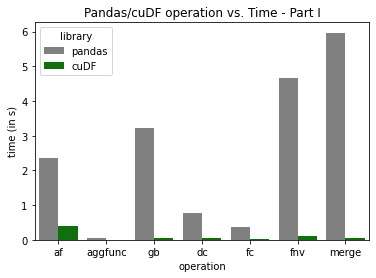

In [45]:
perf_data = pd.DataFrame(np.array(graph_data), columns=['operation', 'time (in s)', 'library'])
perf_data['time (in s)'] = perf_data['time (in s)'].astype(float)
perf_data_p2 = perf_data[perf_data['operation'].isin(["af", "aggfunc", "gb", "dc", "fc", "fnv", "merge"])]
library = perf_data_p2['library']
colors = ['green' if l == 'cuDF' else 'grey' for l in library]
sns.barplot(x='operation', y='time (in s)', hue='library', data=perf_data_p2, palette=colors, ci=None)
plt.title("Pandas/cuDF operation vs. Time - Part I")

## Pandas/cuDF Operation vs. Time - Part II (more intensive DataFrame operations)

Text(0.5, 1.0, 'Pandas/cuDF operation vs. Time - Part II')

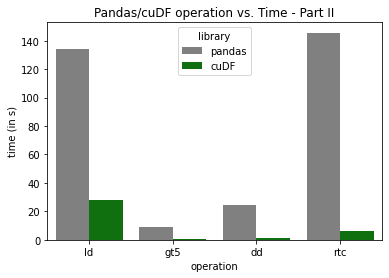

In [46]:
#["ld", "rtc", "dd", "gt5"] --> more intensive
#["af", "aggfunc", "gb", "dc", "fc", "fnv", "merge"] --> less intensive 

perf_data = pd.DataFrame(np.array(graph_data), columns=['operation', 'time (in s)', 'library'])
perf_data['time (in s)'] = perf_data['time (in s)'].astype(float)
perf_data_p1 = perf_data[perf_data['operation'].isin(["ld", "rtc", "dd", "gt5"])]
library = perf_data_p1['library']
colors = ['green' if l == 'cuDF' else 'grey' for l in library]
sns.barplot(x='operation', y='time (in s)', hue='library', data=perf_data_p1, palette=colors, ci=None)
plt.title("Pandas/cuDF operation vs. Time - Part II")

## Operation vs. cuDF Speedup (compared to pandas)

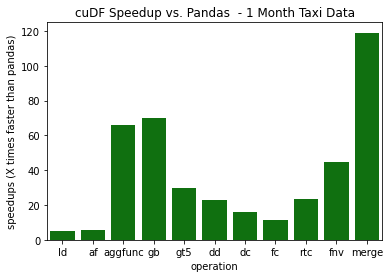

In [47]:
cudf_barplot_data
speedups_df = pd.DataFrame(np.array(cudf_barplot_data), columns=['operation', 'speedups (X times faster than pandas)'])
speedups_df['speedups (X times faster than pandas)'] = speedups_df['speedups (X times faster than pandas)'].astype(float)
colors = ['green' for index, row in speedups_df.iterrows()]
sns.barplot(x='operation', y='speedups (X times faster than pandas)', data=speedups_df, palette=colors, ci=None)
if num_months == 1:
    plt.title("cuDF Speedup vs. Pandas  - 1 Month Taxi Data")
else:
    plt.title("cuDF Speedup vs. Pandas - " + str(num_months) + " Months Taxi Data")
